In [1]:
!pip install tensorflow==2.13.0 tensorflow-compression==2.13.0 tensorflow-probability==0.20.0

Reason for being yanked: TFP 0.20 should require Python 3.8+
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 434.9 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 26.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 15.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 5.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorfl

In [2]:
import tensorflow as tf
import tensorflow_compression as tfc
import os
import random
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
BATCH_SIZE = 64          #Change the batch size if needed

def dataset_generator(dir, mode=None, shuffle=True):
    if mode:
        dataset = image_dataset_from_directory(
            directory=dir,
            label_mode='int',
            labels='inferred',
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            image_size=(32, 32),
            shuffle=shuffle,
            interpolation='bilinear',
            validation_split=0.1,
            subset=mode,
            seed=0
        )
    else:
        dataset = image_dataset_from_directory(
            directory=dir,
            label_mode='int',
            labels='inferred',
            color_mode='rgb',
            batch_size=BATCH_SIZE,
            image_size=(32, 32),
            shuffle=shuffle,
            interpolation='bilinear'
        )

    return dataset


class SemViT(tf.keras.Model):
    def __init__(self, block_types, filters, num_blocks, has_gdn=True,
                 num_symbols=512, snrdB=25, channel='AWGN'):
        '''
        block_types: (list) types of each building blocks
            'V' for ViT block, 'C' for Conv (ResNet) block
            e.g., ['C', 'C', 'V', 'V', 'C', 'C']
        filters: (list) output dimensions for each block
            e.g., [256, 256, 256, 256, 256, 256]
        num_blocks: (list) # of repetition for each block
            e.g., [1, 1, 3, 3, 1, 1]
        has_gdn: (bool) include GDN/IGDN?
        num_symbols: (int) # of total complex symbols sent
            e.g., 512 for 1/6 bandwidth ratio (512 / 32*32*3)
        snrdB: (int) channel snr (in dB)
        channel: (str) channel type ('Rayleigh', 'AWGN', or None)
        '''
        super().__init__()
        if has_gdn:
            gdn_func=tfc.layers.GDN()
            igdn_func=tfc.layers.GDN(inverse=True)
        else:
            gdn_func=tf.keras.layers.Lambda(lambda x: x)
            igdn_func=tf.keras.layers.Lambda(lambda x: x)

        assert len(block_types) == len(filters) == len(num_blocks) == 6, \
               "length of block_types, filters, num_blocks should be 6"
        self.encoder = SemViT_Encoder(
            block_types[:3],
            filters[:3],
            num_blocks[:3],
            num_symbols,
            gdn_func=gdn_func
        )

        if channel == 'Rayleigh':
            self.channel = RayleighChannel(snrdB)
        elif channel == 'AWGN':
            self.channel = AWGNChannel(snrdB)
        elif channel == 'Rician':
            self.channel = RicianChannel(snrdB, k=2)
        else:
            self.channel = tf.identity

        self.decoder = SemViT_Decoder(
            block_types[3:],
            filters[3:],
            num_blocks[3:],
            gdn_func=igdn_func
        )
    
    def call(self, x):
        x = self.encoder(x)
        x = self.channel(x)
        x = self.decoder(x)

        return x


class SemViT_Encoder(tf.keras.layers.Layer):
    def __init__(self, block_types, filters, num_blocks,
                 num_symbols, gdn_func=None, **kwargs):
        super().__init__()
        self.layers = [
            # 32 x 32 input
            build_blocks(0, block_types, num_blocks, filters, 32, kernel_size=9, stride=2, gdn_func=gdn_func),
            # downsampled to 16 x 16
            build_blocks(1, block_types, num_blocks, filters, 16, kernel_size=5, stride=2, gdn_func=gdn_func),
            # downsampled to 8 x 8
            build_blocks(2, block_types, num_blocks, filters, 8, kernel_size=5, gdn_func=gdn_func),
            # to constellation
            tf.keras.layers.Conv2D(
                filters=num_symbols // 8 // 8 * 2,
                # current spatial dimension is 8 x 8
                # and 2 for iq dimension
                kernel_size=1
            )
        ]


    def call(self, x):
        for sublayer in self.layers:
            x = sublayer(x)
        
        b, h, w, c = x.shape
        x = tf.reshape(x, (-1, h*w*c//2, 2))
        return x
    

    def get_config(self):
        config = super().get_config()
        return config


class SemViT_Decoder(tf.keras.layers.Layer):
    def __init__(self, block_types, filters, num_blocks, gdn_func=None, **kwargs):
        super().__init__()
        self.layers = [
            # 8 x 8 input
            build_blocks(0, block_types, num_blocks, filters, 8, kernel_size=5, gdn_func=gdn_func),
            # upsampled to 16 x 16
            tf.keras.layers.Resizing(16, 16),
            build_blocks(1, block_types, num_blocks, filters, 16, kernel_size=5, gdn_func=gdn_func),
            # upsampled to 32 x 32
            tf.keras.layers.Resizing(32, 32),
            build_blocks(2, block_types, num_blocks, filters, 32, kernel_size=9, gdn_func=gdn_func),
            # to image
            tf.keras.layers.Conv2D(
                filters=3,
                kernel_size=1,
                activation='sigmoid'
            )
        ]


    def call(self, x):
        b, c, _ = x.shape
        x = tf.reshape(x, (-1, 8, 8, c*2//64))

        for sublayer in self.layers:
            x = sublayer(x)
        return x
    

    def get_config(self):
        config = super().get_config()
        return config


def build_blocks(layer_idx, block_types, num_blocks, filters, spatial_size, kernel_size=5, stride=1, gdn_func=None):
    assert block_types[layer_idx] in ('C', 'V'), "layer type should be either C or V"

    if block_types[layer_idx] == 'C':
        return build_conv(
            repetition=num_blocks[layer_idx],
            filter_size=filters[layer_idx],
            kernel_size=kernel_size,
            stride=stride,
            gdn_func=gdn_func)
    else:
        return build_vitblocks(
            repetition=num_blocks[layer_idx],
            num_heads=filters[layer_idx]//32,
            head_size=32,
            spatial_size=spatial_size,
            stride=stride,
            gdn_func=gdn_func)


def build_conv(repetition, filter_size, kernel_size=5, stride=1, gdn_func=None):
    x = tf.keras.Sequential()
    for i in range(repetition):
        s = stride if i == 0 else 1
        x.add(tfc.SignalConv2D(
                filter_size,
                kernel_size,
                corr=True,
                strides_down=s,
                padding="same_zeros",
                use_bias=True,
        ))
        if gdn_func:
            x.add(gdn_func)
        x.add(tf.keras.layers.PReLU(shared_axes=[1, 2]))
    return x


def build_vitblocks(repetition, num_heads, head_size, spatial_size, stride=1, gdn_func=None):
    x = tf.keras.Sequential()
    for i in range(repetition):
        s = stride if i == 0 else 1
        x.add(VitBlock(num_heads, head_size, spatial_size, stride=s))
        if gdn_func:
            x.add(gdn_func)
    return x


class SemViT_Encoder_Only(tf.keras.Model):
    def __init__(self, block_types, filters, num_blocks, has_gdn=True,
                 num_symbols=512):
        super().__init__()
        if has_gdn:
            gdn_func=tfc.layers.GDN()
            igdn_func=tfc.layers.GDN(inverse=True)
        else:
            gdn_func=tf.keras.layers.Lambda(lambda x: x)
            igdn_func=tf.keras.layers.Lambda(lambda x: x)

        assert len(block_types) == len(filters) == len(num_blocks) == 6, \
               "length of block_types, filters, num_blocks should be 6"
        self.encoder = SemViT_Encoder(
            block_types[:3],
            filters[:3],
            num_blocks[:3],
            num_symbols,
            gdn_func=gdn_func
        )
    
    def call(self, x):
        x = self.encoder(x)

        return x


class SemViT_Decoder_Only(tf.keras.Model):
    def __init__(self, block_types, filters, num_blocks, has_gdn=True,
                 num_symbols=512):
        super().__init__()
        if has_gdn:
            gdn_func=tfc.layers.GDN()
            igdn_func=tfc.layers.GDN(inverse=True)
        else:
            gdn_func=tf.keras.layers.Lambda(lambda x: x)
            igdn_func=tf.keras.layers.Lambda(lambda x: x)

        assert len(block_types) == len(filters) == len(num_blocks) == 6, \
               "length of block_types, filters, num_blocks should be 6"
        self.decoder = SemViT_Decoder(
            block_types[3:],
            filters[3:],
            num_blocks[3:],
            gdn_func=igdn_func
        )
    
    def call(self, x):
        x = self.decoder(x)

        return x
    



class AWGNChannel(tf.keras.layers.Layer):
    def __init__(self, snrdB=None):
        super().__init__()
        self.snr = 10 ** (snrdB / 10) # in dB
    

    def call(self, x):
        '''
        x: inputs with shape (b, c, 2)
           where last dimension denotes in-phase and quadrature-phase elements, respectively.
        '''
        assert x.shape[2] == 2, "input shape should be (b, c, 2), where last dimension denotes i and q, respectively"
        assert len(x.shape) == 3, "input shape should be (b, c, 2)"

        i = x[:,:,0]
        q = x[:,:,1]

        # power normalization
        sig_power = tf.math.reduce_mean(i ** 2 + q ** 2)
        snr = self.snr

        n = tf.random.normal(
            tf.shape(x),
            mean=0,
            stddev=tf.math.sqrt(sig_power/(2*snr))
        )

        y = x + n
        return y
    

    def get_config(self):
        config = super().get_config()
        return config



class RayleighChannel(tf.keras.layers.Layer):
    def __init__(self, snrdB=None, clip_snrdB=5):
        super().__init__()
        self.snr = 10 ** (snrdB / 10) # in dB
        self.clip_snr = 10 ** (clip_snrdB / 10)
    

    def call(self, x):
        '''
        x: inputs with shape (b, c, 2)
           where last dimension denotes in-phase and quadrature-phase elements, respectively.
        Assumes slow rayleigh fading, where h does not change for single batch data

        We clip the coefficient h to generate short-term SNR between +-5 dB of given long-term SNR.
        '''
        assert x.shape[2] == 2, "input shape should be (b, c, 2), where last dimension denotes i and q, respectively"
        assert len(x.shape) == 3, "input shape should be (b, c, 2)"
        
        i = x[:,:,0]
        q = x[:,:,1]

        # power normalization
        sig_power = tf.math.reduce_mean(i ** 2 + q ** 2)
        
        # batch-wise slow fading
        h = tf.random.normal(
            (1, 1, 2),
            mean=0,
            stddev=tf.math.sqrt(0.5)
        )

        snr = self.snr

        n = tf.random.normal(
            tf.shape(x),
            mean=0,
            stddev=tf.math.sqrt(sig_power/(2*snr))
        )

        yhat = h * x + n

        return yhat
    

    def get_config(self):
        config = super().get_config()
        return config



class RicianChannel(tf.keras.layers.Layer):
    def __init__(self, snrdB=None, k=2):
        super().__init__()
        self.snr = 10 ** (snrdB / 10) # in dB
        self.k = k
    

    def call(self, x):
        '''
        x: inputs with shape (b, c, 2)
           where last dimension denotes in-phase and quadrature-phase elements, respectively.
        Assumes slow rayleigh fading (for NLOS part), where h does not change for single batch data

        We clip the coefficient h to generate short-term SNR between +-5 dB of given long-term SNR.
        '''
        assert x.shape[2] == 2, "input shape should be (b, c, 2), where last dimension denotes i and q, respectively"
        assert len(x.shape) == 3, "input shape should be (b, c, 2)"
        
        i = x[:,:,0]
        q = x[:,:,1]

        # power normalization
        sig_power = tf.math.reduce_mean(i ** 2 + q ** 2)
        
        # batch-wise slow fading
        h = tf.random.normal(
            (1, 1, 2),
            mean=0,
            stddev=tf.math.sqrt(0.5)
        )

        snr = self.snr

        n = tf.random.normal(
            tf.shape(x),
            mean=0,
            stddev=tf.math.sqrt(sig_power/(2*snr))
        )

        k = self.k

        yhat = tf.math.sqrt(1 / (1+k)) * h * x + tf.math.sqrt(k / (1+k)) * x + n

        return yhat
    
    

class MLP(tf.keras.layers.Layer):
    def __init__(self, out_features, expansion_coeff=4):
        super().__init__()

        self.fc1 = tf.keras.layers.Dense(
            out_features * expansion_coeff
        )
        self.gelu = tf.nn.gelu
        self.fc2 = tf.keras.layers.Dense(
            out_features
        )
    
    def call(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x


class RelativeMHSA(tf.keras.layers.Layer):
    '''
    Implements multihead attention 
    with Swin-like learnable 2d relative positional encoding
    '''
    def __init__(self, num_heads, dim_head, spatial_size):
        '''
        num_heads: the number of heads
        dim_head: channel dimensions per head
        spatial_size: height/width of the input
        query/key/value shape: (b, h, w, c) where h == w 
        '''
        super().__init__()

        assert num_heads != 0, "num_heads should be nonzero"

        self.dim_head = dim_head
        self.num_heads = num_heads

        self.qkv = tf.keras.layers.Conv2D(
            filters=dim_head * 3,
            kernel_size=1
        )

        self.head_transform = tf.keras.layers.Conv2D(
            filters=dim_head*num_heads,
            kernel_size=1
        )

        # build rel. pos parameter and bias index here
        h = spatial_size
        pos_emb_idx_horizontal = tf.tile(tf.constant(
            [range(i, i+h) for i in range(0, -h, -1)]),
            multiples=[h, h]
        )

        pos_emb_idx_vertical = tf.repeat(
            tf.repeat(
                tf.constant([range(i, i+h)
                             for i in range(0, -h, -1)]),
                repeats=h,
                axis=0
            ),
            repeats=h,
            axis=-1
        )

        pos_emb_idx = (2*h-1) * (pos_emb_idx_vertical + h - 1) + \
                      (pos_emb_idx_horizontal + h - 1)

        self.pos_emb_idx = pos_emb_idx

        initializer = tf.keras.initializers.GlorotNormal()
        self.learned_pos_emb = tf.Variable(
            initializer(shape=((2*h-1)**2,))
        )


    def call(self, x):
        b, h, w, c = x.shape
        m = self.num_heads

        assert c % m == 0, "channel dimension should be divisible " \
               f"with number of heads, but c={c} and m={m} found"
        d_h = c//m

        # [b, h, w, c] to [b, m, h, w, c//m]
        x = tf.reshape(x, (-1, h, w, m, d_h))
        x = tf.transpose(x, (0, 3, 1, 2, 4))

        x = self.qkv(x)
        x = tf.reshape(x, (-1, h*w, self.dim_head, 3))
        q = x[:, :, :, 0]
        k = x[:, :, :, 1]
        v = x[:, :, :, 2]

        # normalize with sqrt(d)
        q = q / tf.sqrt(tf.constant(self.dim_head, tf.float32))

        # attention map computation; q, k: (b*m, h*w, d_h)
        att_map = tf.einsum('bic,bjc->bij', q, k)

        # add rel. pos. encoding to attention map
        pos_emb = tf.gather(self.learned_pos_emb, self.pos_emb_idx)

        att_map = att_map + pos_emb
        att_map = tf.nn.softmax(att_map)
        
        v = tf.reshape(v, (-1, h*w, self.dim_head))
        v = tf.einsum('bij,bjc->bic', att_map, v)

        # [b, m, h, w, c//m] to [b, h, w, c]
        v = tf.reshape(v, (-1, m, h, w, c//m))
        v = tf.transpose(v, (0, 2, 3, 1, 4))
        v = tf.reshape(v, (-1, h, w, c))

        v = self.head_transform(v)
        return v


class VitBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, head_size,
                 spatial_size, stride=1):
        '''
        num_heads: the number of heads
        head_size: channel dimensions per head
        spatial_size: height/width of the input
                      (before downsampling)
        patchmerge: (boolean) 1/2 downsampling before MHSA
        '''
        super().__init__()

        d_out = num_heads * head_size
        self.ln1 = tf.keras.layers.LayerNormalization()

        self.patchmerge = tf.keras.layers.Conv2D(
            filters=d_out,
            kernel_size=stride,
            strides=stride,
        )
        spatial_size //= stride

        self.mhsa = RelativeMHSA(
            num_heads=num_heads,
            dim_head=head_size,
            spatial_size=spatial_size
        )

        self.ln2 = tf.keras.layers.LayerNormalization()
        self.mlp = MLP(d_out)

    def call(self, x):
        x = self.patchmerge(x)
        x = self.ln1(x)
        x_residual = x

        x = self.mhsa(x) 
        x = tf.add(x, x_residual)
        
        x_residual = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = tf.add(x, x_residual)

        return x





os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'





def prepare_dataset():
  AUTO = tf.data.experimental.AUTOTUNE
  test_ds = dataset_generator('/kaggle/input/cifar10-pngs-in-folders/cifar10/test/')           #Give the correct paths
  train_ds = dataset_generator('/kaggle/input/cifar10-pngs-in-folders/cifar10/train/').cache()

  normalize = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  augment_layer = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    ])

  def normalize_and_augment(image, training):
    image = augment_layer(image, training=training)
    return image

  train_ds = (
    train_ds.shuffle(50000, reshuffle_each_iteration=True)
            .map(lambda x, y: (normalize_and_augment(x, training=True), y), num_parallel_calls=AUTO)
            .map(lambda x, _: (x, x))
            .prefetch(AUTO)
  )
  test_ds = (
    test_ds.map(lambda x, y: (normalize(x), y))
           .map(lambda x, _: (x, x))
           .cache()
           .prefetch(AUTO)
  )

  return train_ds, test_ds

def main(config):
    if config['gpu']:
        os.environ["CUDA_VISIBLE_DEVICES"] = config['gpu']

    # Load CIFAR-10 dataset
    train_ds, test_ds = prepare_dataset()

    EXPERIMENT_NAME = config['experiment_name']
    print(f'Running {EXPERIMENT_NAME}')

    model = SemViT(
        config['block_types'],
        config['filters'],
        config['repetitions'],
        has_gdn=config['gdn'],
        num_symbols=config['data_size'],
        snrdB=config['train_snrdB'],
        channel=config['channel_types']
    )

    def psnr(y_true, y_pred):
        return tf.image.psnr(y_true, y_pred, max_val=1)

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.legacy.Adam(
            learning_rate=1e-4
        ),
        metrics=[
            psnr
        ]
    )

    model.build(input_shape=(None, 32, 32, 3))
    model.summary()

    if config['ckpt'] is not None:
        model.load_weights(config['ckpt'])

    save_ckpt = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"./ckpt/{EXPERIMENT_NAME}_" + f"{config['epochs']}",
            save_best_only=True,
            monitor="val_loss",
            save_weights_only=True,
            options=tf.train.CheckpointOptions(
                experimental_io_device=None, experimental_enable_async_checkpoint=True
            )
        )
    ]

    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f'logs/{EXPERIMENT_NAME}')
    history = model.fit(
        train_ds,
        initial_epoch=config['initial_epoch'],
        epochs=config['epochs'],
        callbacks=[tensorboard, save_ckpt],
        validation_data=test_ds,
    )

    model.save_weights(f"{EXPERIMENT_NAME}_" + f"{config['epochs']}")

# Run the main function with the config dictionary

In [4]:
config = {
    'data_size': 512,
    'channel_types': 'AWGN',
    'train_snrdB': 10,
    'block_types': 'CCVVCC',
    'experiment_name': 'experiment_1',
    'epochs': 10,
    'filters': [256, 256, 256, 256, 256, 256],
    'repetitions': [1, 1, 3, 3, 1, 1],
    'gdn': False,
    'initial_epoch': 0,
    'ckpt': '/kaggle/input/vit-597/CCVVCC_512_10dB_599',
    'gpu': '0'
}

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
def imBatchtoImage(batch_images):
    '''
    turns b, 32, 32, 3 images into single sqrt(b) * 32, sqrt(b) * 32, 3 image.
    '''
    batch, h, w, c = batch_images.shape
    b = int(batch ** 0.5)

    divisor = b
    while batch % divisor != 0:
        divisor -= 1
    
    image = tf.reshape(batch_images, (-1, batch//divisor, h, w, c))
    image = tf.transpose(image, [0, 2, 1, 3, 4])
    image = tf.reshape(image, (-1, batch//divisor*w, c))
    return image

In [7]:
model = SemViT(
    config['block_types'],
    config['filters'],
    config['repetitions'],
    has_gdn=config['gdn'],
    num_symbols=config['data_size'],
    snrdB=config['train_snrdB'],
    channel=config['channel_types']
)

In [8]:
model.load_weights(config['ckpt'])

In [9]:
# Load and preprocess the image
image_path = '/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR/0002.png'
image = Image.open(image_path).convert('RGB')
image = np.array(image)

# Rescale to [0, 1]
image = image / 255.0

# Break the image into 32x32 patches
patches = tf.image.extract_patches(
    images=tf.expand_dims(image, axis=0),
    sizes=[1, 32, 32, 1],
    strides=[1, 32, 32, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

# Reshape patches to (batch_size, 32, 32, 3)
patches = tf.reshape(patches, (-1, 32, 32, 3))


In [10]:
# Step 1: Encode the input image
encoded_data = model.encoder(patches)

In [11]:
# Step 2: Simulate passing the encoded data through a channel
transmitted_data = model.channel(encoded_data)  # This uses the channel defined in the SemViT model
#transmitted_data = encoded_data # Without channel 

In [12]:
# Step 3: Decode the transmitted data back to an image
decoded_patches = model.decoder(transmitted_data)

In [14]:
reconstructed_image = imBatchtoImage(decoded_patches)

In [15]:
# Post-process reconstructed image (rescale to [0, 255])
reconstructed_image = np.clip(reconstructed_image * 255, 0, 255).astype(np.uint8)

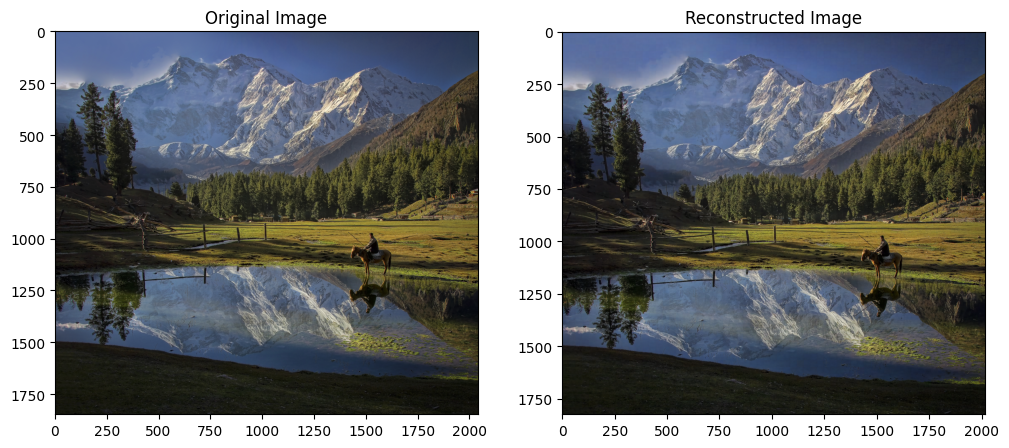

In [16]:
# Display the original and reconstructed image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.show()

In [18]:
reconstructed_image_normalized = reconstructed_image / 255.0

In [19]:
psnr_value = tf.image.psnr(image, reconstructed_image_normalized, max_val=1.0)

InvalidArgumentError: {{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [1848,2040,3] vs. [1824,2016,3] [Op:SquaredDifference] name: 

In [21]:
image.shape

(1848, 2040, 3)

In [22]:
reconstructed_image_normalized.shape

(1824, 2016, 3)

In [ ]:
print(f"PSNR: {psnr_value.numpy():.2f} dB")

**Correction for PSNR**

In [24]:
# Load and preprocess the image
image_path = '/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR/0002.png'
image = Image.open(image_path).convert('RGB')
image = np.array(image)

print(image.shape)

# Resize the image to be divisible by 32 (adjusting dimensions)
height, width = image.shape[:2]
new_height = (height // 32) * 32
new_width = (width // 32) * 32
image = tf.image.resize(image, [new_height, new_width])
image = np.array(image)

# Rescale to [0, 1]
image = image / 255.0
print(image.shape)

(1848, 2040, 3)
(1824, 2016, 3)


256x256

In [35]:
from PIL import Image
import numpy as np

# Load and preprocess the image
image_path = '/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR/0002.png'
image = Image.open(image_path).convert('RGB')

# Resize the image to 256x256 using LANCZOS
resized_image = image.resize((256, 256), Image.LANCZOS)

# Convert to numpy array and rescale to [0, 1]
resized_image = np.array(resized_image) / 255.0

print(resized_image.shape)  # Should print (256, 256, 3)


(256, 256, 3)


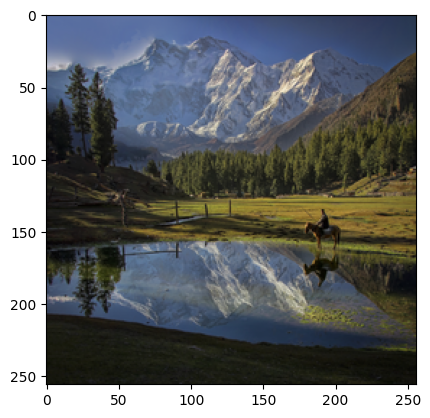

In [36]:
plt.imshow(resized_image)
plt.show()

256x256

In [37]:
image = resized_image

In [38]:
# Break the image into 32x32 patches
patches = tf.image.extract_patches(
    images=tf.expand_dims(image, axis=0),
    sizes=[1, 32, 32, 1],
    strides=[1, 32, 32, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

# Reshape patches to (batch_size, 32, 32, 3)
patches = tf.reshape(patches, (-1, 32, 32, 3))

In [39]:
# Step 1: Encode the input image
encoded_data = model.encoder(patches)

In [40]:
# Step 2: Simulate passing the encoded data through a channel
transmitted_data = model.channel(encoded_data)  # This uses the channel defined in the SemViT model
#transmitted_data = encoded_data # Without channel 

In [41]:
# Step 3: Decode the transmitted data back to an image
decoded_patches = model.decoder(transmitted_data)

In [42]:
reconstructed_image = imBatchtoImage(decoded_patches)

# Post-process reconstructed image (rescale to [0, 255])
reconstructed_image = np.clip(reconstructed_image * 255, 0, 255).astype(np.uint8)
reconstructed_image = reconstructed_image / 255.0

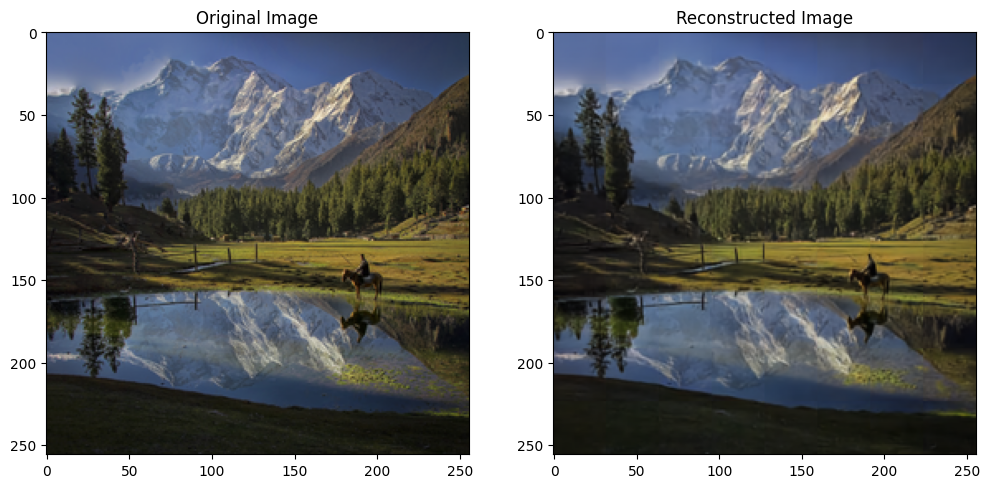

In [43]:
# Display the original and reconstructed image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.show()

In [44]:
psnr_value = tf.image.psnr(image, reconstructed_image, max_val=1.0)
print(f"PSNR: {psnr_value.numpy():.2f} dB")

PSNR: 35.14 dB


In [45]:
psnr_value = tf.image.psnr(image, image, max_val=1.0)
print(f"PSNR: {psnr_value.numpy():.2f} dB")

PSNR: inf dB


In [46]:
type(encoded_data)

tensorflow.python.framework.ops.EagerTensor

In [47]:
print(encoded_data)

tf.Tensor(
[[[ 1.1700071  -1.4405049 ]
  [-0.78027946 -2.1964622 ]
  [ 1.437349    0.28862864]
  ...
  [ 1.4757595   0.20146923]
  [ 0.8315547  -1.1818011 ]
  [-0.23982906 -0.29667908]]

 [[ 1.3171176  -1.2119392 ]
  [-0.94641834 -1.7614919 ]
  [ 1.3721563   0.28801233]
  ...
  [-0.5526876  -1.420024  ]
  [-0.8245374   2.812781  ]
  [-2.4910514  -2.459815  ]]

 [[ 0.44794568 -0.9167839 ]
  [-0.9634243  -1.4921799 ]
  [ 1.8548214  -0.15129416]
  ...
  [-0.10888444  1.354545  ]
  [-3.256322   -1.5260451 ]
  [ 4.2987447  -0.5865566 ]]

 ...

 [[-0.5824067   0.08731429]
  [ 1.5109731  -0.4115602 ]
  [-3.522216   -2.6133187 ]
  ...
  [-0.19560854  1.8350009 ]
  [ 1.4781865   1.6866022 ]
  [ 0.3014431   2.3401444 ]]

 [[ 1.8920406  -0.42179316]
  [ 0.01995733 -2.5370393 ]
  [-0.79190993  0.02464042]
  ...
  [ 0.29837245  1.5716664 ]
  [-0.32359165 -1.004472  ]
  [-1.3754627   2.0703015 ]]

 [[ 2.9336052  -2.2133088 ]
  [ 2.3441994  -2.7965899 ]
  [-1.2643585  -0.1369864 ]
  ...
  [-0.2678974

All in 1

In [ ]:
from PIL import Image
import numpy as np

# Load and preprocess the image
image_path = '/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR/0002.png'
image = Image.open(image_path).convert('RGB')

# Resize the image to 256x256 using LANCZOS
resized_image = image.resize((256, 256), Image.LANCZOS)

# Convert to numpy array and rescale to [0, 1]
resized_image = np.array(resized_image) / 255.0

print(resized_image.shape)  # Should print (256, 256, 3)

image = resized_image


# Break the image into 32x32 patches
patches = tf.image.extract_patches(
    images=tf.expand_dims(image, axis=0),
    sizes=[1, 32, 32, 1],
    strides=[1, 32, 32, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

# Reshape patches to (batch_size, 32, 32, 3)
patches = tf.reshape(patches, (-1, 32, 32, 3))


# Step 1: Encode the input image
encoded_data = model.encoder(patches)

# Step 2: Simulate passing the encoded data through a channel
transmitted_data = model.channel(encoded_data)  # This uses the channel defined in the SemViT model
#transmitted_data = encoded_data # Without channel 

# Step 3: Decode the transmitted data back to an image
decoded_patches = model.decoder(transmitted_data)

reconstructed_image = imBatchtoImage(decoded_patches)

# Post-process reconstructed image (rescale to [0, 255])
reconstructed_image = np.clip(reconstructed_image * 255, 0, 255).astype(np.uint8)
reconstructed_image = reconstructed_image / 255.0

In [48]:
type(transmitted_data)

tensorflow.python.framework.ops.EagerTensor

In [53]:
# Convert the encoded_data to a NumPy array
encoded_data_np = transmitted_data.numpy()
with open('encoded_data1.txt', 'w') as file:
    # Iterate over the slices
    for i in range(encoded_data_np.shape[0]):
        file.write(f'Slice {i}:\n')
        # Flatten the 2D slice to 1D for saving
        np.savetxt(file, encoded_data_np[i].reshape(-1, encoded_data_np.shape[2]), fmt='%.5f', delimiter=',')
        file.write('\n\n')

print("Encoded data saved to 'encoded_data.txt'.")

Encoded data saved to 'encoded_data.txt'.


In [57]:
numpy_array = transmitted_data.numpy()

# Convert the numpy array to a Python list
python_list = numpy_array.tolist()

# Define the path for your text file
txtfile = '/path/to/your/file.txt'

# Write the Python list to the text file
with open('encoded_data1.txt', 'w') as text_file:
    for item in python_list:
        text_file.write(str(item) + '\n')

print(f"Saved EagerTensor as a list in {txtfile}")

Saved EagerTensor as a list in /path/to/your/file.txt


In [59]:
transmitted_data.shape

TensorShape([64, 512, 2])

In [58]:
print(transmitted_data)

tf.Tensor(
[[[ 0.65979403 -1.2748646 ]
  [-1.4142734  -1.8565881 ]
  [ 1.869827    0.6763389 ]
  ...
  [ 0.79093546 -1.9750488 ]
  [ 0.92633224 -1.656553  ]
  [-1.7891326   1.1889098 ]]

 [[ 0.91837037 -1.015956  ]
  [-1.0667608  -2.3491182 ]
  [ 1.7882283   0.02180505]
  ...
  [-1.4058022  -1.5016658 ]
  [-1.3440335   2.192755  ]
  [-2.7131054  -3.4736767 ]]

 [[ 0.80321866 -1.9644274 ]
  [-0.9720701  -2.1372848 ]
  [ 0.6525787  -0.5290092 ]
  ...
  [ 0.10356705 -0.06442273]
  [-3.8463259  -2.438623  ]
  [ 4.7540264  -0.29904944]]

 ...

 [[-0.27497694  1.0560749 ]
  [ 1.5123832  -1.0349259 ]
  [-3.71428    -2.6730857 ]
  ...
  [ 0.40357888  1.6832614 ]
  [ 0.4905932   1.7143284 ]
  [-0.23739034  1.5875311 ]]

 [[ 2.508882   -1.555265  ]
  [ 0.23589122 -2.0721002 ]
  [ 0.10976911  0.23533493]
  ...
  [ 0.25597093  1.0063044 ]
  [-1.2474236   0.35774553]
  [-0.6926069   0.97965205]]

 [[ 3.755956   -3.1197457 ]
  [ 2.864625   -4.4648705 ]
  [-1.8241425   0.07571697]
  ...
  [-0.2591175